# Graph convolutional networks

Resources:

- https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-7d2250723780
- https://github.com/tkipf/pygcn
- http://tkipf.github.io/graph-convolutional-networks/

## Setup

In [210]:
import math

import numpy as np
import scipy.sparse as sp
from networkx import karate_club_graph, to_numpy_matrix
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

## Dataset

In [93]:
# Load the dataset
zkc = karate_club_graph()
order = sorted(list(zkc.nodes()))

# Build the adjency matrix A
A = to_numpy_matrix(zkc, nodelist=order)  # 34x34 shape

## Pytorch Model

### Utils

In [243]:
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    
    return mx

### Layers

In [263]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter("bias", None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, X, adj):
        support = torch.mm(X, self.weight)
        output = torch.spmm(adj, support)

        if self.bias is not None:
            output = output + self.bias
        
        return output

    def __repr__(self):
        return "{0} ({1} -> {2})".format(self.__class__.__name__,
                                         self.in_features,
                                         self.out_features)

### Model

In [264]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

### Training

#### Prepare training data

In [298]:
# Add identity matrix --> A_hat
assert np.allclose(np.asarray(A.diagonal()), np.zeros(A.shape[0]))
A_hat = A + sp.eye(A.shape[0])
assert np.allclose(np.asarray(A_hat.diagonal()), np.ones(A_hat.shape[0]))

# Normalize A_hat
A_hat_norm = normalize(A_hat)
assert A_hat_norm.shape == A.shape
assert np.allclose(np.asarray(A_hat_norm.sum(axis=1)), np.ones((A.shape[0], 1)))

In [299]:
# As we have no features, use the identity matrix
features = np.eye(A.shape[0])
features = normalize(features)  # useless for now

In [300]:
# Convert to torch tensor
A_hat_norm = torch.FloatTensor(np.asarray(A_hat_norm))
features = torch.FloatTensor(features)

In [301]:
model = GCN(nfeat=features.shape[1],
            nhid=4,
            nclass=2,
            dropout=.3)

optimizer = optim.Adam(model.parameters(),
                       lr=.05,
                       weight_decay=.01)

In [302]:
model.train()
optimizer.zero_grad()
output = model(features, A_hat_norm)

### Visualizing the hidden representation

In [303]:
X_hid = output.data.numpy()

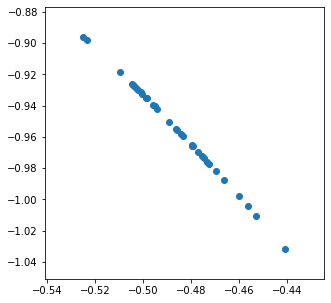

In [304]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x=X_hid[:, 0], y=X_hid[:, 1])
plt.show()